# Dados Faltantes (<em>Missing Data</em>)

Imaginar que os dados obtidos de sensores irão sempre produzir <em>datasets</em> limpos pode ser considerado uma utopia. Diversos problemas podem ocorrer no processo de aquisição de dados ou no transporte desses até a Nuvem, como problemas físicos com o <em>hardware</em> dos sensores, falta de energia, problemas de conectividade, dentre outros.
É comum que os <em>datasets</em> apresentem dados faltantes, duplicados, confusos, insuficientes ou que tenha presença de valores atípicos (<em>outliers</em>). Em resumo, dados faltantes são inevitáveis. 

Para ajudar a solucionar problemas como este, cientistas e analistas de dados ou analistas de negócios devem conhecer a natureza pela qual o conjunto de dados analizado pertence. Por exemplo, num <em>dataset</em> que representa dados ambientais de localidades, não é comum que encontremos um valor de temperatura igual a 9999. Não é um valor esperado para temperatura (neste caso).

Existem algumas técnicas para trabalhar com <strong>dados faltantes</strong>, mas as que abordaremos neste curso são a <strong>imputação</strong> e <strong>interpolação</strong>.

Todos os exemplos utilizados nesta prática são baseados nos mesmos exemplos do livro <a href="https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook">Time Series Analysis with Python - Cookbook</a>

## Requisitos técnicos
Iremos trabalhar com dois <em>datasets</em> nos exemplos:
- Emissões de CO2, com dados anuais obtidos através de relatórios do portal <a href="https://ourworldindata.org/">Our World in Data</a>. Disponível em <a href="https://ourworldindata.org/co2-emissions">https://ourworldindata.org/co2-emissions</a>.
- Fluxo de cliques em e-shop, disponível em <a href="https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping">https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping</a>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np

Será necessário o uso intenso da biblioteca pandas e outras quatro bibliotecas:
- Numpy (≥ 1.20.3)
- Matplotlib (≥ 3.5.0)
- statsmodels (≥ 0.11.0)
- scikit-learn (≥ 1.0.1)
- SciPy (≥ 1.7.1)

Se você estiver usando pip, basta instalar os pacotes com o seguinte comando no seu terminal:
 ```
 pip install matplotlib numpy statsmodels scikit-learn scipy
```

Se você estiver usando conda, então você pode instalar as bibliotecas com o seguinte comando:
```
conda install matplotlib numpy statsmodels scikit-learn scipy
```

In [16]:
import matplotlib
import sklearn
import statsmodels as sm

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
''')



pandas -> 1.3.5
numpy -> 1.21.6
matplotlob -> 3.2.2
statsmodels -> 0.12.2
scikit-learn -> 1.0.2



### Funções necessárias para as práticas

#### ```read_dataset()```

In [17]:
def read_dataset(url, date_col):
    '''
     date_col: especifica uma coluna de data para ser usada como coluna de índice
    
    Por praticidade e pela possibilidade de executar este notebook na Nuvem, opta-se pela utilização de 
    URL's para obter o dataset. Caso você queira utilizar datasets localmente em sua máquina, comente 
    as linhas abaixo que não estão comentadas e descomente as que estão comentadas'''
    df = pd.read_csv(url, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    '''
    #dir: é um objeto de Path #(necessário importar a biblioteca: from pathlib import Path) 
    #arquivo: o nome do arquivo CSV no objeto Path

   
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    '''
    
    #  retorna: pandas DataFrame com um DatetimeIndex
    return df

#### ```plot_df()```

Esta função "plota" gráficos de séries temporais usando uma coluna de parâmetro (```col```). Esta coluna contém os dados faltantes. 

O objetivo da função é comparar dois dataframes: ```df1``` (dataframe original, sem dados faltantes) e ```df2``` para comparar ambos

In [18]:
def plot_df(df1, df2, col, titulo=None, xlabel=None, ylabel=None):
    '''	
    df1: dataframe original (sem dados faltantes)
    df2: dataframe com dados faltantes
    col: nome da coluna que contém dados faltantes
    '''    
    df_f = df2.rename(columns={col: 'faltante'})
    
    colunas = df_f.loc[:, 'faltante':].columns.tolist()
    subplots_t = len(colunas)
   
    fig, ax = plt.subplots(subplots_t+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = titulo 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Dataset Original')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, nomecol in enumerate(colunas):
        df_f[nomecol].plot(ax=ax[i+1])
        ax[i+1].set_title(nomecol)

    plt.show()

### ```indice_rmse()```

Existem algumas abordagens que podem ser adotadas para lidar com dados faltantes. Algumas são mais apropriadas para determinados cenários. Algumas a se destacar:
1. Remoção dos dados faltantes (não indicado, principalmente quando se tem um conjunto pequeno de dados)
2. Criar "etiquetas" para identificar dados faltantes. Ex.: (Se em algum dia, você descobriu que houve falha de energia, você poderia informar isso nos dias em que houve essa falha, para distinguir registros faltantes dos não faltantes)
3. Estimar os dados faltantes. Abriga um conjunto de técnicas que vão desde o simples até o mais sofisticado (de técnicas de ML até modelos estatísticos complexos).
Nós utilizaremos a "raiz quadrada média de erro" (do inglês <em>root mean square error</em> - RSME) entre os valores observados e preditos, conforme a fórmula abaixo:
<img src=" 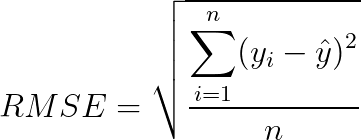"></img>

Onde:
- $Y_i$ é o valor observado
- $\hat{Y}$ é o valor predito (no nosso exemplo, seria o valor faltante)

RSME será utilizada por nós para avaliar os múltiplos métodos de imputação de dados. A técnica é muito utilizada para avaliar a perfomance de modelos preditivos (por exemplo, comparar modelos de regressão). Geralmente, quanto menor o valor RSME, melhor. Ou seja, a fórmula nos diz a distância média entre o valor predito (no nosso caso, onde há dados faltantes) e o valor atual.

In [19]:
def indice_rmse(df1, df2, col=None):
    '''
    df1: dataframe original (sem dados faltantes)
    df2: dataframe com dados faltantes
    col: nome da coluna que contém dados faltantes

    retorna: a lista de índices
    '''
    df_f = df2.rename(columns={col: 'faltante'})
    colunas = df_f.loc[:, 'faltante':].columns.tolist()
    scores = []
    for comp_col in df_f[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_f[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE de {comp_col}: {rmse}')
    return scores

## Realizando testes de qualidade

Dados faltantes podem representar valores facilmente distinguíveis dos "normais", como
- ```NaN```, ```NaT``` ou ```NA```
- Podem ser substituídos por valores quantitativos, como ```9999``` ou ```0``` (valores com ```0``` sempre devem ser investigados) e valores qualitativos (por exemplo, ```missing```)

# Estratégias para imputação de dados

Como aprendemos anteriormente, há duas principais técnicas para lidar com dados faltantes: a imputação e a interolação de dados.

À seguir, iremos aprender a utilizar tais técnicas. Primeiramente, utilizaremos a imputação, que pode ser:
1. Univariada: envolve uma única variável (coluna) para substituir dados faltantes. Mais simples e rápida, porém  produz resultados menos eficientes.
2. Multivariada: utiliza múltiplas variáveis para completar os dados faltantes.

## 1- Manipulando dados ausentes com imputação univariada usando pandas

Para esta estratégia, algumas técnicas que podem ser aplicadas são:
- Imputação usando a média
- Imputação usando a técnica da "última observação à frente" (<em>forward fill</em>)
- Imputação usando a técnica da "próxima observação para trás" (<em>backward fill</em>)

Abaixo, iremos utilizar dois <em>datasets</em> para incompletos e analisar as melhores estratégias, para cada caso. 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
co2_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/co2_original.csv', index_col=0)
co2_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/co2_missing_only.csv', index_col=0)
clicks_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_original.csv', index_col=0)
clicks_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_missing.csv', index_col=0)

In [22]:
co2_faltante.isnull().sum()

co2    35
dtype: int64

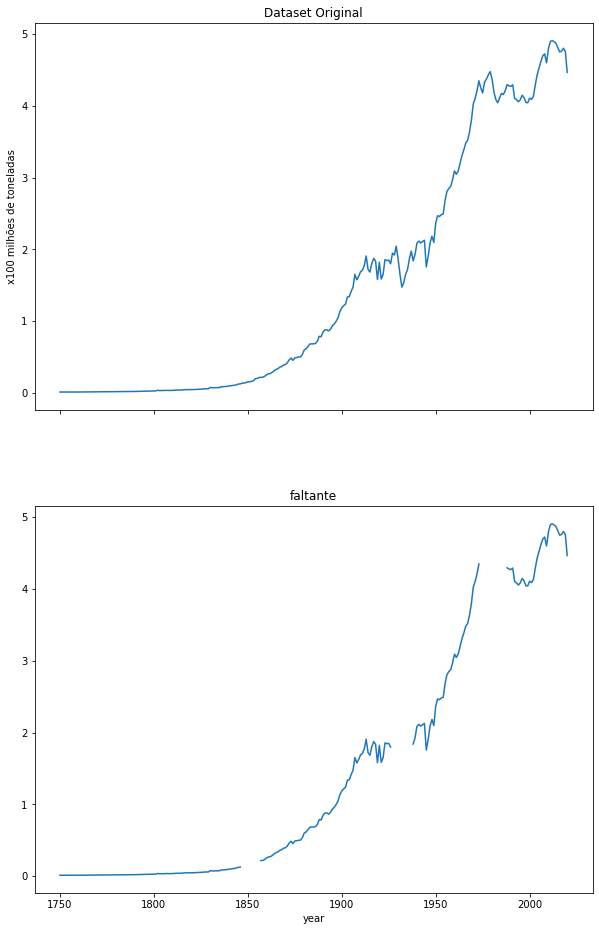

In [23]:
plot_df(co2_original, 
         co2_faltante, 
         'co2',
         titulo="Emissão Anual de CO2 per-capta",
         xlabel="Anos",
         ylabel="x100 milhões de toneladas")

In [24]:
co2_faltante['ffill'] = co2_faltante['co2'].fillna(method='ffill')
co2_faltante['bfill'] = co2_faltante['co2'].fillna(method='bfill')
co2_faltante['mean'] = co2_faltante['co2'].fillna(co2_faltante['co2'].mean())

In [25]:
#Calculando o erro quadrático médio
_ = indice_rmse(co2_original, 
                    co2_faltante, 
                    'co2')
#Como podemos analisar ao executar esta célula, a melhor estratégia para este dataset foi bfill (mais próximo de 0)
#Ambos as técnicas bfill e ffill produzem melhores resultados do que uso da média

RMSE de faltante: 0.0
RMSE de ffill: 0.05873012599267133
RMSE de bfill: 0.05550012995280968
RMSE de mean: 0.7156383637041684


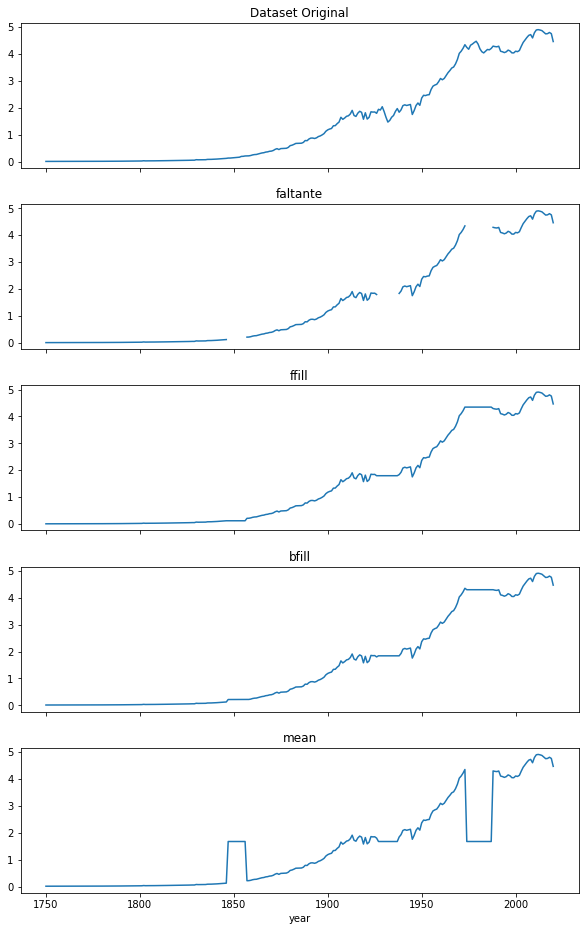

In [26]:
plot_df(co2_original, co2_faltante, 'co2')


#### Agora é sua vez de fazer o mesmo com o dataset de clicks em e-shops. Qual seria a melhor estatégia para este <em>dataset</em>?

## 2- Manipulando dados ausentes com imputação univariada usando Scikit-Learn

* Usando Sckit-Learn ```SimpleImputer```

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [28]:
co2_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/co2_original.csv', index_col=0)
co2_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/co2_missing_only.csv', index_col=0)
clicks_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_original.csv', index_col=0)
clicks_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_missing.csv', index_col=0)

In [29]:

display(clicks_original) # Exibe o Dataframe

,price,location,clicks
date,,,
4/1/08,43.155647,2,18784
4/2/08,43.079056,1,24738
4/3/08,43.842609,2,15209
4/4/08,43.312376,1,14018
4/5/08,43.941176,1,11974
...,...,...,...
8/9/08,44.182033,1,6716
8/10/08,43.608260,1,9523
8/11/08,43.553363,1,8881


In [30]:
display(clicks_faltante) # Exibe o Dataframe

,price,location,clicks
date,,,
4/1/08,43.155647,2,18784.0
4/2/08,43.079056,1,24738.0
4/3/08,43.842609,2,15209.0
4/4/08,43.312376,1,14018.0
4/5/08,43.941176,1,11974.0
...,...,...,...
8/9/08,44.182033,1,6716.0
8/10/08,43.608260,1,9523.0
8/11/08,43.553363,1,8881.0


In [31]:
### Descobrir se tem valores vazios e a quantidade deles em cada coluna

#print(train.isna().any()) # Exibe como True ou False os valores do Dataframe
print(clicks_faltante.isna().sum()) # Exibe a soma dos valores no Dataframe

price        0
location     0
clicks      16
dtype: int64


In [32]:
print(clicks_faltante.isna().any()) # Exibe como True ou False os valores do Dataframe

price       False
location    False
clicks       True
dtype: bool


In [33]:
estrategia = [
    ('Estratégia da média', 'mean'),
    ('Estratégia da mediana', 'median'),
    ('Estratégia do "mais frequente"', 'most_frequent')]

In [36]:
#Transformando o arranjo 1D (226,) para um array de forma 2d (226,1)
clicks_valores = clicks_faltante['clicks'].values.reshape(-1,1)


for s_name, s in estrategia:
    clicks_faltante[s_name] = (SimpleImputer(strategy=s).fit_transform(clicks_valores)) 

In [37]:
_ = indice_rmse(clicks_original, clicks_faltante, 'clicks')

RMSE de price: 10406.550235597697
RMSE de location: 10444.288595172926
RMSE de faltante: 0.0
RMSE de Estratégia da média: 997.7600138929953
RMSE de Estratégia da mediana: 959.3580492530756
RMSE de Estratégia do "mais frequente": 1097.6425985146868


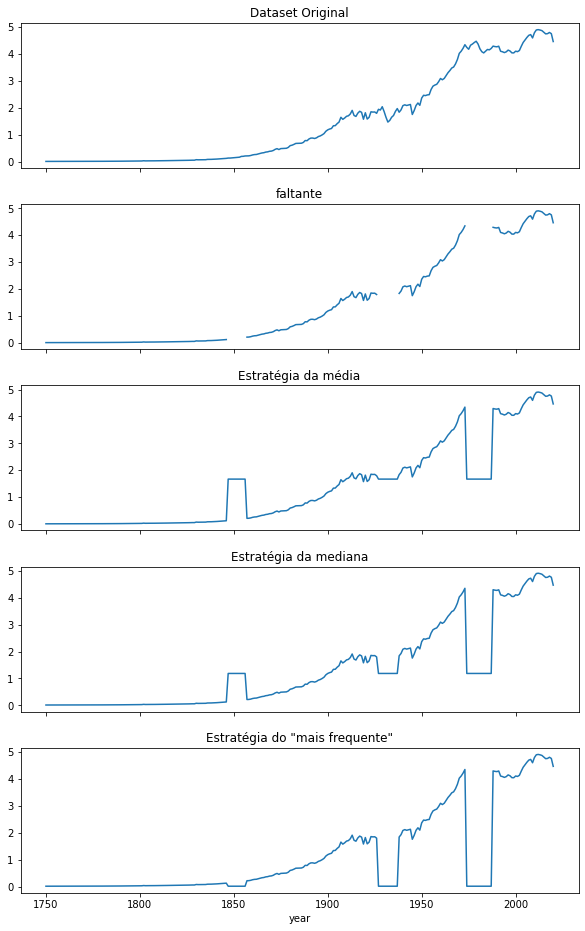

In [ ]:
plot_df(co2_original, co2_faltante, 'co2')

#### Agora é sua vez de fazer o mesmo com o dataset de clicks em e-shops. Qual seria a melhor estatégia para este <em>dataset</em>?

## 3- Manipulando dados ausentes com imputação multivariada

 Nesta abordagem, utilizaremos apenas o <em>dataset</em> sobre clicks em e-shops pelo fato de que o <em>dataset</em> de emissões de CO2 contempla apenas uma coluna. Utilizaremos também a biblioteca scikitlearn para esta abordagem (mais especificamente a classe ```InterativeImputer```, que permite um regressor para prever dados faltantes de outros variáveis do <em>dataset</em>).

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [39]:
clicks_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_original.csv', index_col=0)
clicks_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_missing.csv', index_col=0)

In [40]:
clicks_faltante.isna().sum()

price        0
location     0
clicks      16
dtype: int64

In [41]:
#lista de regressores (estimadores) para serem usados com InterativeImputer
estimadores = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]

In [42]:
#Iterando os estimadores e treinando o dataset (usando .fit()) e aplicando a imputação (usando .transform())

clicks_valores = clicks_faltante.iloc[:,0:3].values


for e_name, e in estimadores:
    est = IterativeImputer(
                random_state=15,
                estimator=e).fit(clicks_valores)
    clicks_faltante[e_name] = est.transform(clicks_valores)[: , 2]

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [43]:
#Repare que a Regressão Linear Bayseana, Rede Elástica e Regressão Linear produzem resultados muito próximos
_ = indice_rmse(clicks_original, clicks_faltante, 'clicks')

RMSE de price: 10406.550235597697
RMSE de location: 10444.288595172926
RMSE de faltante: 0.0
RMSE de bayesianRidge: 949.439397345585
RMSE de extra_trees: 1825.128500580063
RMSE de bagging: 1413.3830627781515
RMSE de elastic_net: 945.4075209343099
RMSE de linear_regression: 938.9419831427186
RMSE de knn: 1336.8798392251822


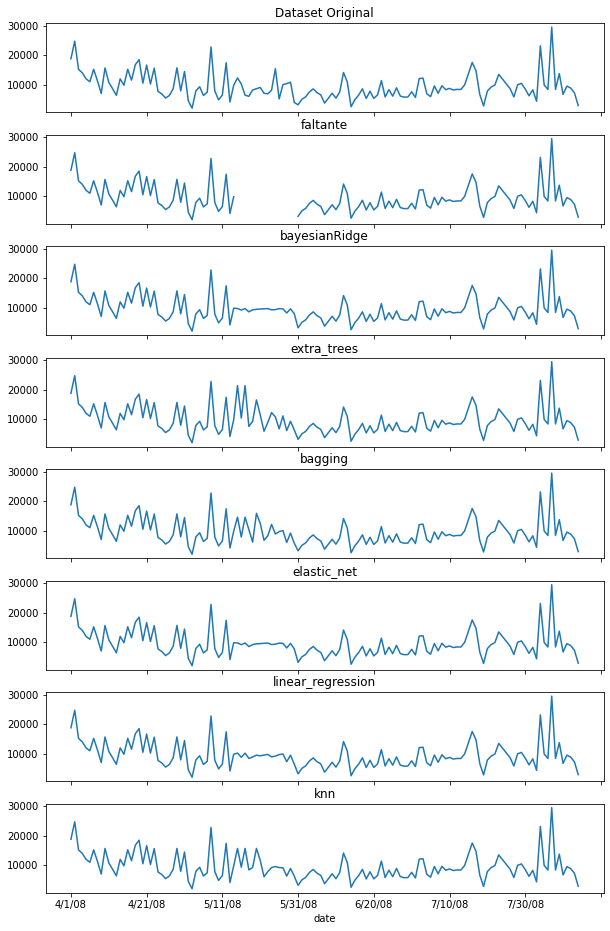

In [44]:
plot_df(clicks_original, clicks_faltante, 'clicks')

#### Uma informação importante: como nem sempre saberemos a natureza dos dados que tentaremos tratar, o que nos interessa é ter um modelo interessante para completar nossos dados faltantes (não só analisar o índice RMSE.) Neste último exemplo, podemos perceber que os três modelos que menor índice RMSE apresentaram (Regressão Linear Bayseana, Rede Elástica e Regressão Linear) não capturaram algumas aleatoriedades nos dados.
#### No geral, a imputação multivariada apresenta melhores resultados do que imputação univariada. Se percebe isso ainda melhor quando temos um dataset mais complexo, com mais variáveis a se observar.

## 4- Manipulando dados ausentes com interpolação

Outra técnica utilizada para completar dados ausentes é a interpolação. Algumas técnicas que são aplicadas aqui são:
- [Interpolação Lienar](https://pt.wikipedia.org/wiki/Interpola%C3%A7%C3%A3o_linear)
- [Interpolação Quadrática](https://magedkamel.com/2a-quadratic-interpolation/)
- [Interpolação por Vizinho mais próximo](https://pt.wikipedia.org/wiki/Interpola%C3%A7%C3%A3o_por_vizinho_mais_pr%C3%B3ximo)
- [Interpolação por spline cúbica](https://acervolima.com/interpolacao-de-spline-cubica/)
- Interpolação de spline

A biblioteca pandas oferece o método ```interpolate()``` que nos permite investigar os diferentes tipos possíveis de interpolação.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
co2_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/co2_original.csv', index_col=0)
co2_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/co2_missing_only.csv', index_col=0)
clicks_original = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_original.csv', index_col=0)
clicks_faltante = pd.read_csv('https://raw.githubusercontent.com/mvscti/GTI04019-COMPUTACAO_EM_NUVEM_E_IOT_II/dados_faltantes/dados_faltantes/datasets/clicks_missing.csv', index_col=0)

In [ ]:
#Utilizando o método interpolate()
co2_faltante.interpolate()

,co2
year,
1750,0.0125
1760,0.0128
1770,0.0150
1780,0.0169
1790,0.0206
...,...
2016,4.7496
2017,4.7595
2018,4.8022


In [ ]:
interpolacoes = [
    'linear',
    'quadratic',
    'nearest',
    'cubic'
]

for intp in interpolacoes:
    co2_faltante[intp] = co2_faltante['co2'].interpolate(method=intp)

'''
Há dois parâmetros extras obrigatórios para interpolações 'spline' e 'polynomial', que é o parâmetro order. 
Utilizaremos o valor 3 para 'polynomial'. O parâmetro determina a ordem (grau) do polinômio
utilizado. Leia a documentação: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
'''
co2_faltante['spline'] = co2_faltante['co2'].interpolate(method='spline', order=3)
co2_faltante['polynomial'] = co2_faltante['co2'].interpolate(method='polynomial',order=3)

In [ ]:
#'Linear' e 'Vizinho mais próximo' tiveram comportamento muito próximo
_ = indice_rmse(co2_original, co2_faltante, 'co2')

RMSE de faltante: 0.0
RMSE de linear: 0.05507291327761665
RMSE de quadratic: 0.08379426414550523
RMSE de nearest: 0.05385422309469095
RMSE de cubic: 0.08386511852488955
RMSE de spline: 0.17765268351873093
RMSE de polynomial: 0.08386511852488955


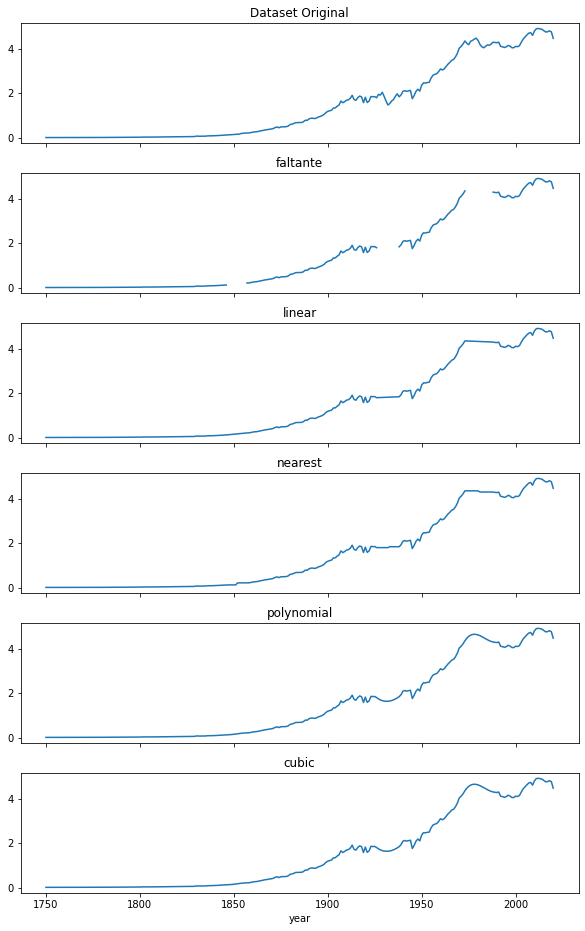

In [ ]:
colunas = ['co2', 'linear', 'nearest', 'polynomial', 'cubic']
plot_df(co2_original, co2_faltante[colunas], 'co2')

#### Agora é sua vez de fazer o mesmo com o dataset de clicks em e-shops. Qual seria a melhor estatégia para este <em>dataset</em>?